In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## goal: we want to find patterns in train.csv that help us predict whether the passengers in test.csv survived.

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
gender_data = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
gender_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [5]:
count_missing_vals = train_data.isnull().sum()
print(count_missing_vals)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [6]:
mean_age = round(train_data["Age"].mean())
train_data.fillna({"Age": mean_age}, inplace=True)

In [7]:
train_data["Age"].isnull().sum()

0

In [8]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.758889,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002570,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
# filter train_data for numeric values to conduct numeric data analysis
num_train_data = train_data.select_dtypes(include=['number'])
train_corr_matrix = num_train_data.corr()
train_corr_matrix

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.033019,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.070657,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.329727,0.083081,0.018443,-0.549500
Age,0.033019,-0.070657,-0.329727,1.000000,-0.232440,-0.180330,0.090632
SibSp,-0.057527,-0.035322,0.083081,-0.232440,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.180330,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.090632,0.159651,0.216225,1.000000


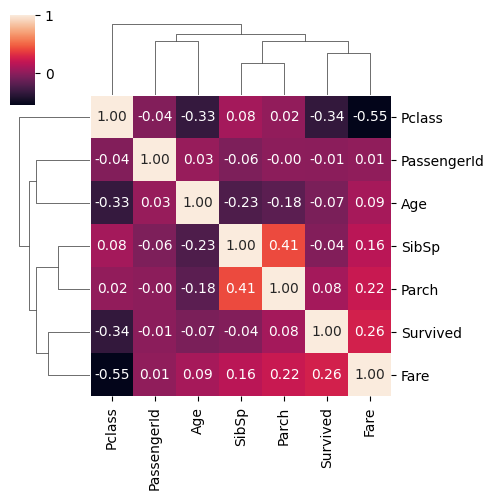

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.triu(np.ones_like(train_corr_matrix))
sns.clustermap(train_corr_matrix,
               annot=True,
              fmt='.2f',
              figsize=(5,5))

In [11]:
# begin ML trying with SVM Classification first
from sklearn import svm

# 77.5% accurary 
y = train_data["Survived"]
features = ["Pclass", "Sex", "SibSp", "Parch"]

X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

clf = svm.SVC()
clf.fit(X, y)

predictions = clf.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

In [12]:
# now try
# adding different features
# scaling all features
# using different kernels
# grid search for best hyperparameters
# try random forest and/or XGBoost

In [13]:
# add a feature called "family_size" (siblings + parents)
# and add kfold cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

train_data["family_size"] = train_data["SibSp"] + train_data["Parch"]
test_data["family_size"] = test_data["SibSp"] + test_data["Parch"]

y = train_data["Survived"]
features = ["Pclass", "Sex", "family_size"]

X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])


kf = KFold(n_splits=5)
kf.get_n_splits(X)

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    # print(f"Fold: {i}")
    # print(f"Train index={train_index}")
    # print(f"Test index={test_index}")

    # use iloc or else KeyError
    clf = svm.SVC(C=1.0, kernel='rbf', random_state=42)
    clf.fit(X.iloc[train_index], y.iloc[train_index]) # train on subset
    
    y_pred = clf.predict(X.iloc[test_index]) # validate 
    accuracy = accuracy_score(y.iloc[test_index], y_pred)

    print(f"Fold: {i}, accuracy: {accuracy}")
    
    


Fold: 0, accuracy: 0.8212290502793296
Fold: 1, accuracy: 0.8033707865168539
Fold: 2, accuracy: 0.8033707865168539
Fold: 3, accuracy: 0.7808988764044944
Fold: 4, accuracy: 0.8314606741573034


In [14]:
# try with grid search
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X, y)
# GridSearchCV(estimator=SVC(),
#              param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})